# Image segmentation using U-Net architecture CNN

## Introduction to U-net

U-net architecture is a particular sequence of deep learning tools (convolution and pooling layers). Below, is the schematic representation of U-Net architecture. It was initially proposed in https://arxiv.org/pdf/1505.04597.pdf.

<img src="u_net.png">

In this notebook, we are going to use this deep learning method to segment FLAIR abnormalities in brain MRI images. This dataset is from Kaggle (https://www.kaggle.com/mateuszbuda/lgg-mri-segmentation).

#### Defining used libraries, and some parameters

In [1]:
import tensorflow as tf
import os
import numpy as np
import random

from tqdm import tqdm

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [91]:
start = 40
end = 100

In [92]:
img_width = 128
img_height = 128
img_channels = 3

In [93]:
X_train_path = '../mrihs/original/100/'
Y_train_path = '../mrihs/label/100label/'

In [94]:
train_X_ids = next(os.walk(X_train_path))[1]

In [95]:
train_dim = 0
for i in range(len(train_X_ids)):
    path = X_train_path+train_X_ids[i]
    temp_imgs = next(os.walk(path))[2]
    train_dim = train_dim + len(temp_imgs)      

In [172]:
train_dim = (end-start)*len(train_X_ids)

#### Importing data

- Each patient's data consists of 189 2D images (slice). Around 15% out of 189 have indicated FLAIR abnormalities.
- In this notebook, I decided to upload only a fraction of data (around 30%). I did it, in order to solve a smaller problem, which is localization. If I imported all the images, then I had to solve 2 problems (localization, and identifying whether there is an abnormalty in the image)

In [97]:
X = np.zeros((train_dim, img_width, img_height, img_channels), dtype = np.uint8)
print('Resizing training images')
counter = 0
for n, id_ in tqdm(enumerate(train_X_ids), total = len(train_X_ids)):
    path = X_train_path + id_
    temp_imgs = next(os.walk(path))[2]
    for i in range(start, end):
        img = imread(path+"/"+temp_imgs[i])
        img = resize(img, (img_height, img_width), mode = 'constant', preserve_range = True)
        X[counter] = img
        counter = counter+1

Resizing training images


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:25<00:00,  3.87it/s]


In [98]:
Y = np.zeros((train_dim, img_width, img_height, 1), dtype = np.bool)

print('Resizing training masks')
counter = 0
for n, id_ in tqdm(enumerate(train_X_ids), total = len(train_X_ids)):
    path = Y_train_path + id_
    l_r = next(os.walk(path))[1]
    
    if len(l_r)==1:
        if "_L" in l_r[0]:
            path_r = ""
            path_l = path+"/"+l_r[0]+"/"
            l = next(os.walk(path_l))[2]
        if "_R" in l_r[0]:
            path_l = ""
            path_r = path+'/'+l_r[1]+"/"
            r = next(os.walk(path_r))[2]
            
    if len(l_r)==2:
        path_l = path+"/"+l_r[0]+"/"
        l = next(os.walk(path_l))[2]
        
        path_r = path+'/'+l_r[1]+"/"
        r = next(os.walk(path_r))[2]
        
    
    for i in range(start, end):
        mask = np.zeros((img_height, img_width, 1), dtype = np.bool)
        
        if path_l != "":
            mask_l = imread(path_l + l[i], as_gray = True)
            mask_l = np.expand_dims(resize(mask_l, (img_height, img_width), mode = 'constant', preserve_range = True), axis = -1)
            test = np.zeros(mask_l.shape)
            for j in range(mask_l.shape[0]):
                for k in range(mask_l.shape[1]):
                    if mask_l[j][k]*255>100:
                        test[j][k]=255
            mask = np.maximum(mask, test)
        
        if path_r !="":
            mask_r = imread(path_r + r[i], as_gray=True)
            mask_r = np.expand_dims(resize(mask_r, (img_height, img_width), mode = 'constant', preserve_range = True), axis = -1)
            test = np.zeros(mask_r.shape)
            for j in range(mask_r.shape[0]):
                for k in range(mask_r.shape[1]):
                    if mask_r[j][k]*255>100:
                        test[j][k]=255
                        
            mask = np.maximum(mask, test)
            
        Y[counter] = mask
        counter = counter + 1

Resizing training masks


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [07:05<00:00,  4.25s/it]


#### Splitting data for training and validation

In [99]:
X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.1, random_state = 2020)

#### Model definition using Keras

In [100]:
inputs = tf.keras.layers.Input((img_width, img_height, img_channels))
#input pixels should be in float for keras layers
#inputs = tf.keras.Lambda(lambda x: x / 255.0)(inputs)

# contracting path(encoding)

c1 = tf.keras.layers.Conv2D(16, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(inputs)
#kernel_initializer: we have to start with some values in the filter
c1 = tf.keras.layers.Dropout(0.1)(c1)
#2nd convolution layer
c1 = tf.keras.layers.Conv2D(16, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c1)
#pooling layer
p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(p2)
c3 = tf.keras.layers.Dropout(0.1)(c3)
c3 = tf.keras.layers.Conv2D(64, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(p3)
c4 = tf.keras.layers.Dropout(0.1)(c4)
c4 = tf.keras.layers.Conv2D(128, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c4)
p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(p4)
c5 = tf.keras.layers.Dropout(0.1)(c5)
c5 = tf.keras.layers.Conv2D(256, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c5)

# expanding path(decoding)

u6 = tf.keras.layers.Conv2DTranspose(128, (2,2), strides = (2,2), padding = 'same')(c5)
u6 = tf.keras.layers.concatenate([u6,c4])
c6 = tf.keras.layers.Conv2D(128, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(u6)
c6 = tf.keras.layers.Dropout(0.1)(c6)
c6 = tf.keras.layers.Conv2D(128, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2,2), strides = (2,2), padding = 'same')(c6)
u7 = tf.keras.layers.concatenate([u7,c3])
c7 = tf.keras.layers.Conv2D(64, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(u7)
c7 = tf.keras.layers.Dropout(0.1)(c7)
c7 = tf.keras.layers.Conv2D(64, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2,2), strides = (2,2), padding = 'same')(c7)
u8 = tf.keras.layers.concatenate([u8,c2])
c8 = tf.keras.layers.Conv2D(32, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2,2), strides = (2,2), padding = 'same')(c8)
u9 = tf.keras.layers.concatenate([u9,c1])
c9 = tf.keras.layers.Conv2D(16, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c9)

outputs = tf.keras.layers.Conv2D(1, (1,1), activation = 'sigmoid')(c9)

model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 128, 128, 16) 448         input_2[0][0]                    
__________________________________________________________________________________________________
dropout_9 (Dropout)             (None, 128, 128, 16) 0           conv2d_19[0][0]                  
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 128, 128, 16) 2320        dropout_9[0][0]                  
____________________________________________________________________________________________

In [101]:
# callbacks
checkpointer = tf.keras.callbacks.ModelCheckpoint('BRAIN_2.h5', verbose = 1, save_best_only = True)
early = tf.keras.callbacks.EarlyStopping(patience = 2, monitor = 'val_loss')
t_board = tf.keras.callbacks.TensorBoard(log_dir = 'logs')

callbacks = [checkpointer, early, t_board]

#### Fitting the model for training data

In [102]:
results = model.fit(X_train, y_train, validation_data = (X_valid, y_valid), batch_size = 16, epochs = 3, 
                    callbacks = callbacks)

Train on 5400 samples, validate on 600 samples
Epoch 1/3
2944/5400 [===============>..............] - ETA: 8:48 - loss: 6.8278 - accuracy: 0.57 - ETA: 6:30 - loss: 4.0393 - accuracy: 0.68 - ETA: 5:44 - loss: 2.8587 - accuracy: 0.76 - ETA: 5:18 - loss: 2.1897 - accuracy: 0.81 - ETA: 5:02 - loss: 1.7789 - accuracy: 0.85 - ETA: 4:51 - loss: 1.5042 - accuracy: 0.87 - ETA: 4:43 - loss: 1.3060 - accuracy: 0.89 - ETA: 4:37 - loss: 1.1509 - accuracy: 0.90 - ETA: 4:32 - loss: 1.0390 - accuracy: 0.91 - ETA: 4:29 - loss: 0.9489 - accuracy: 0.92 - ETA: 4:26 - loss: 0.8795 - accuracy: 0.93 - ETA: 4:23 - loss: 0.8187 - accuracy: 0.93 - ETA: 4:22 - loss: 0.7718 - accuracy: 0.94 - ETA: 4:20 - loss: 0.7345 - accuracy: 0.94 - ETA: 4:19 - loss: 0.6990 - accuracy: 0.94 - ETA: 4:18 - loss: 0.6682 - accuracy: 0.95 - ETA: 4:17 - loss: 0.6393 - accuracy: 0.95 - ETA: 4:15 - loss: 0.6174 - accuracy: 0.95 - ETA: 4:15 - loss: 0.5946 - accuracy: 0.95 - ETA: 4:14 - loss: 0.5706 - accuracy: 0.96 - ETA: 4:12 - loss: 

2976/5400 [===============>..............] - ETA: 4:09 - loss: 0.0063 - accuracy: 0.99 - ETA: 4:05 - loss: 0.0090 - accuracy: 0.99 - ETA: 4:03 - loss: 0.0075 - accuracy: 0.99 - ETA: 4:02 - loss: 0.0073 - accuracy: 0.99 - ETA: 4:01 - loss: 0.0077 - accuracy: 0.99 - ETA: 4:00 - loss: 0.0078 - accuracy: 0.99 - ETA: 3:59 - loss: 0.0075 - accuracy: 0.99 - ETA: 3:58 - loss: 0.0074 - accuracy: 0.99 - ETA: 3:58 - loss: 0.0079 - accuracy: 0.99 - ETA: 3:57 - loss: 0.0077 - accuracy: 0.99 - ETA: 3:56 - loss: 0.0074 - accuracy: 0.99 - ETA: 3:56 - loss: 0.0077 - accuracy: 0.99 - ETA: 3:55 - loss: 0.0079 - accuracy: 0.99 - ETA: 3:54 - loss: 0.0082 - accuracy: 0.99 - ETA: 3:54 - loss: 0.0083 - accuracy: 0.99 - ETA: 3:54 - loss: 0.0083 - accuracy: 0.99 - ETA: 3:53 - loss: 0.0080 - accuracy: 0.99 - ETA: 3:52 - loss: 0.0079 - accuracy: 0.99 - ETA: 3:51 - loss: 0.0082 - accuracy: 0.99 - ETA: 3:50 - loss: 0.0086 - accuracy: 0.99 - ETA: 3:50 - loss: 0.0087 - accuracy: 0.99 - ETA: 3:49 - loss: 0.0087 - accu

5392/5400 [============================>.] - ETA: 1:49 - loss: 0.0085 - accuracy: 0.99 - ETA: 1:48 - loss: 0.0085 - accuracy: 0.99 - ETA: 1:47 - loss: 0.0085 - accuracy: 0.99 - ETA: 1:47 - loss: 0.0085 - accuracy: 0.99 - ETA: 1:46 - loss: 0.0085 - accuracy: 0.99 - ETA: 1:45 - loss: 0.0085 - accuracy: 0.99 - ETA: 1:44 - loss: 0.0085 - accuracy: 0.99 - ETA: 1:44 - loss: 0.0085 - accuracy: 0.99 - ETA: 1:43 - loss: 0.0085 - accuracy: 0.99 - ETA: 1:42 - loss: 0.0084 - accuracy: 0.99 - ETA: 1:42 - loss: 0.0085 - accuracy: 0.99 - ETA: 1:41 - loss: 0.0084 - accuracy: 0.99 - ETA: 1:40 - loss: 0.0084 - accuracy: 0.99 - ETA: 1:39 - loss: 0.0084 - accuracy: 0.99 - ETA: 1:39 - loss: 0.0084 - accuracy: 0.99 - ETA: 1:38 - loss: 0.0084 - accuracy: 0.99 - ETA: 1:37 - loss: 0.0084 - accuracy: 0.99 - ETA: 1:36 - loss: 0.0084 - accuracy: 0.99 - ETA: 1:36 - loss: 0.0084 - accuracy: 0.99 - ETA: 1:35 - loss: 0.0084 - accuracy: 0.99 - ETA: 1:34 - loss: 0.0084 - accuracy: 0.99 - ETA: 1:34 - loss: 0.0084 - accu

In [103]:
# load the best model
#model.load_weights('BRAIN_2.h5')

#### Applying model on training and validation data for predictions

In [104]:
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

600/600 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 6s 10ms/sample


In [201]:
# Threshold predictions
preds_train_t = (preds_train > 0.9).astype(np.uint8)
preds_val_t = (preds_val > 0.9).astype(np.uint8)

In [253]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 3, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0])
    if has_mask:
        ax[0].contour(y[ix].squeeze(), levels=[0.5])
    ax[0].set_title('Brain')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Mask')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), levels=[0.5])
    ax[2].set_title('Mask Predicted')

## Analysis of model on training data
- 1st image is the image of the brain (with the mask as contour)
- 2nd image is the image of the mask
- 3rd image is predicted mask and actual mask as contour

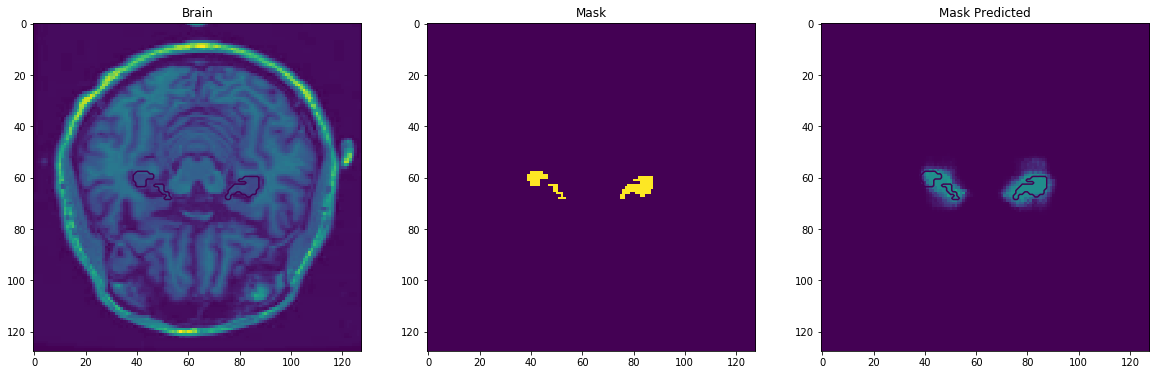

In [255]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

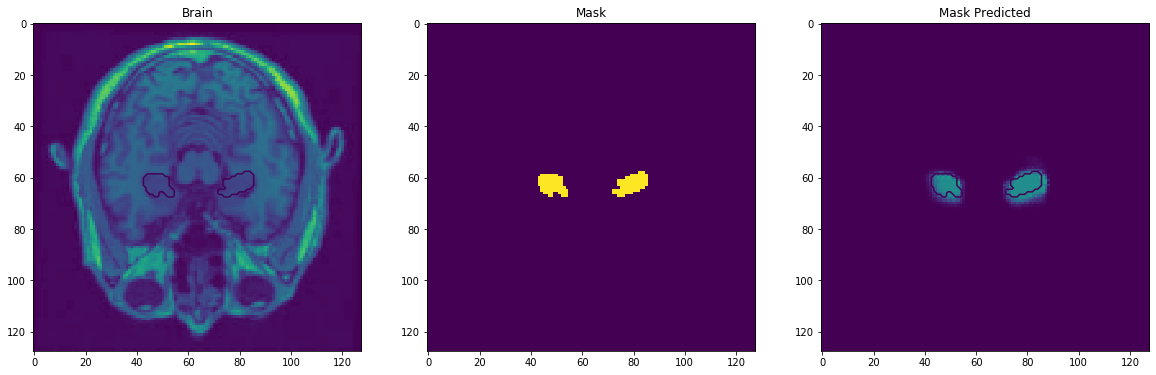

In [256]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

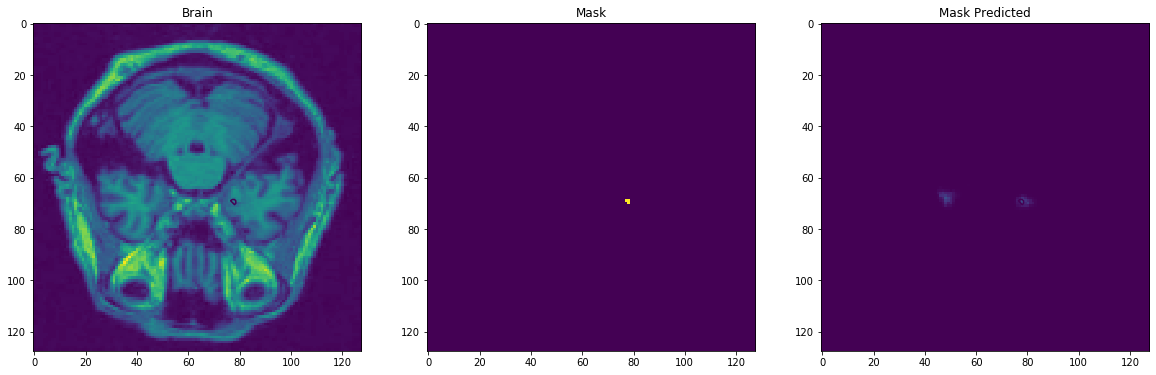

In [259]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

## Analysis of model on validation data
##### Here we check our model on the data, that was not used for training

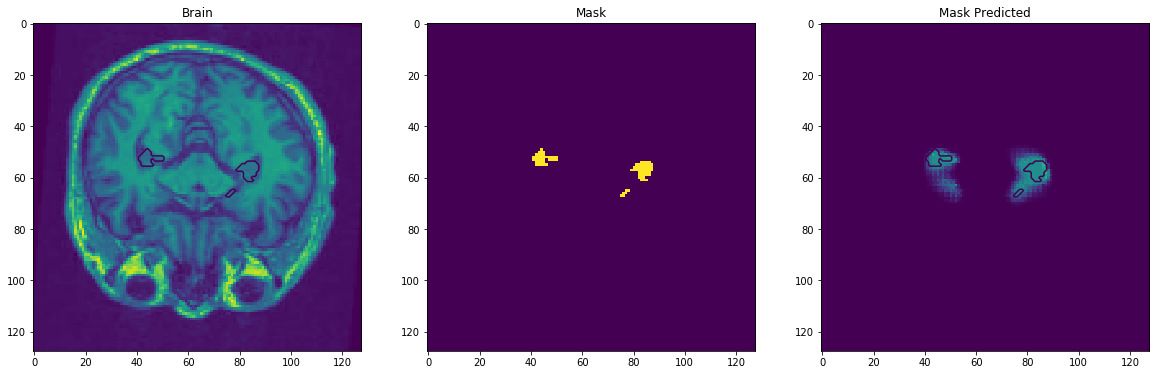

In [264]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

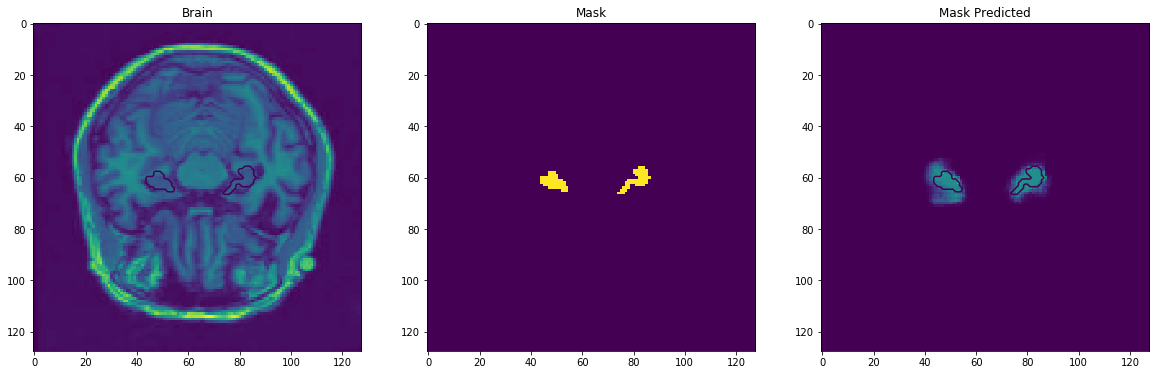

In [266]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

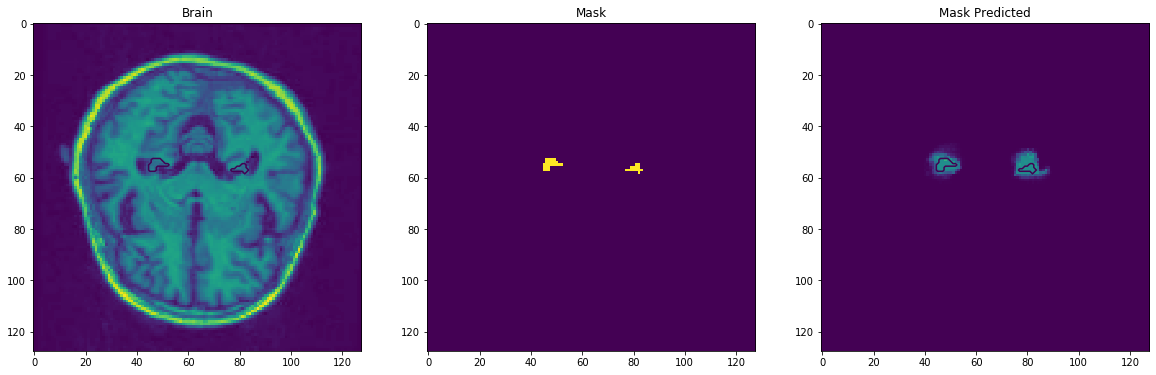

In [273]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

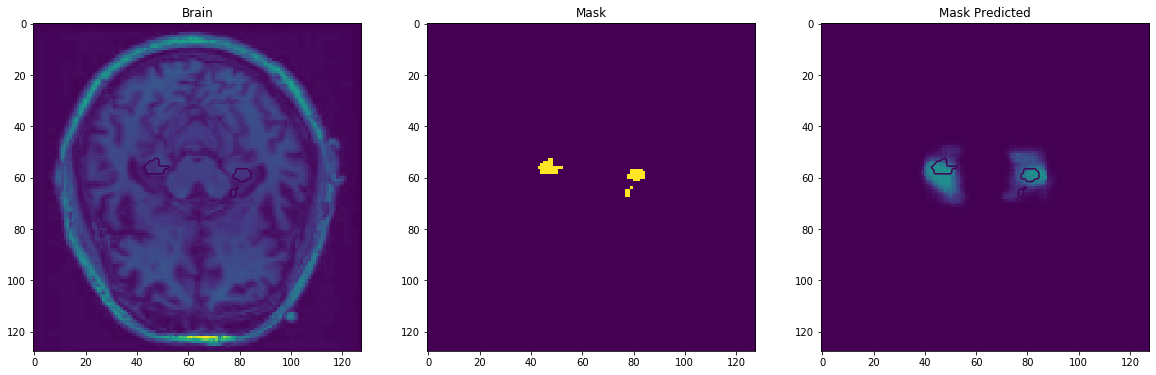

In [283]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

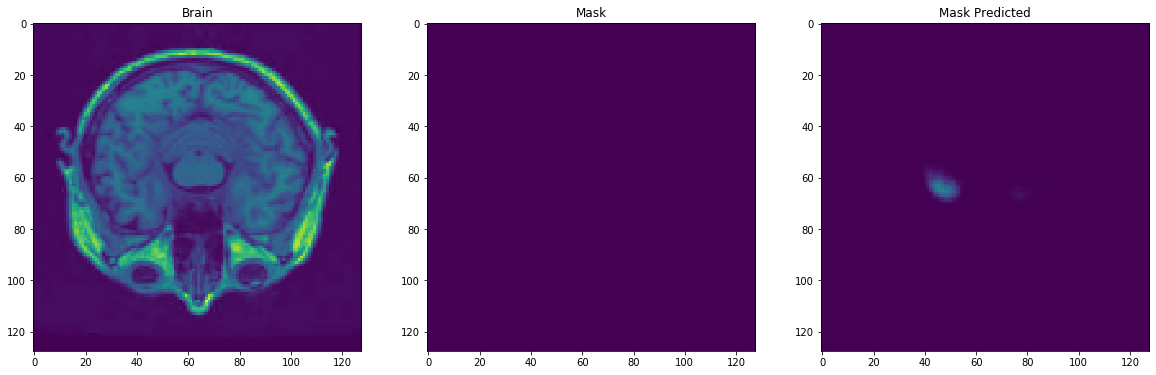

In [305]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

# Bottom line

- As you can see, model seems to work.
- However, there are some mispredictions. To mitigate the, we can tune parameters, such as:
    - number of epochs
    - batch size
    - Validation to training ratio
- Also, we need to keep in mind the following:
    - runtime length. I ran this model using CPUs, thats why I chose 3 epochs only. However, increasing number of epochs might increase the chance of over-fitting. I believe that this skill will be developed with increasing domain knowledge, and deep learning skills

### As a follow-up, we can try to apply different algorithms from Traditional ML 